# Data Preparation for XGBoost Model

This notebook prepares the cleaned stock data for use with the XGBoost model. XGBoost is a powerful gradient boosting framework that can be used for regression and classification tasks.

Unlike Prophet (which requires specific 'ds' and 'y' columns) or LSTM (which requires sequences), XGBoost works with tabular data where:
- Features are organized in columns 
- Each row represents an observation
- Target variables are separated from features

We'll process each of the 20 stock datasets and format them appropriately for XGBoost.

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
%matplotlib inline

## 1. Define Stock List and Data Paths

In [ ]:
# List of stock symbols
stocks = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", 
          "META", "NVDA", "SPY", "V", "DIS",
          "NFLX", "PYPL", "BABA", "IBM", "AMD",
          "BA", "INTC", "T", "GS", "NKE"]

# Paths for input and output data

# Path to the project root (go up 2 levels from this file)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Correct paths
input_folder = os.path.join(project_root, "data", "cleaned")
output_folder = os.path.join(project_root, "data", "xgboost", "initial")
scaler_folder = os.path.join(project_root, "models", "scalers")

# Ensure output and scaler directories exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(scaler_folder, exist_ok=True)

## 2. XGBoost Data Preparation Function

For XGBoost, we need to:
1. Engineer relevant features (technical indicators, time-based features)
2. Handle missing values
3. Scale numeric features
4. Create target variables (regression - next day price, classification - price direction)
5. Organize features and targets

In [5]:
def prepare_xgboost_data(df, stock_symbol):
    """
    Prepare stock data for XGBoost model.
    
    Parameters:
    - df: Cleaned dataframe with stock data
    - stock_symbol: Stock ticker symbol for saving scaler
    
    Returns:
    - DataFrame formatted for XGBoost
    """
    # Create a copy to avoid modifying the original
    xgb_df = df.copy()
    
    # Ensure date is in datetime format
    xgb_df['date'] = pd.to_datetime(xgb_df['date'], utc=True)
    
    # Sort by date to ensure chronological order
    xgb_df = xgb_df.sort_values('date')
    
    # 1. Create additional features
    
    # Time-based features
    xgb_df['day_of_week'] = xgb_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    xgb_df['month'] = xgb_df['date'].dt.month  # 1-12
    xgb_df['day_of_month'] = xgb_df['date'].dt.day  # 1-31
    xgb_df['quarter'] = xgb_df['date'].dt.quarter  # 1-4
    xgb_df['is_month_start'] = xgb_df['date'].dt.is_month_start.astype(int)  # 0 or 1
    xgb_df['is_month_end'] = xgb_df['date'].dt.is_month_end.astype(int)  # 0 or 1
    
    # Price features (if not already in the dataframe)
    if 'ma5' not in xgb_df.columns:
        xgb_df['ma5'] = xgb_df['close'].rolling(window=5).mean()
    if 'ma20' not in xgb_df.columns:
        xgb_df['ma20'] = xgb_df['close'].rolling(window=20).mean()
    if 'ma50' not in xgb_df.columns:
        xgb_df['ma50'] = xgb_df['close'].rolling(window=50).mean()
    
    # Volatility and momentum indicators
    if 'volatility' not in xgb_df.columns:
        xgb_df['volatility'] = xgb_df['close'].rolling(window=20).std()
    if 'volume_ma20' not in xgb_df.columns and 'volume' in xgb_df.columns:
        xgb_df['volume_ma20'] = xgb_df['volume'].rolling(window=20).mean()
    if 'return' not in xgb_df.columns:
        xgb_df['return'] = xgb_df['close'].pct_change()
    
    # Additional technical indicators
    # RSI (Relative Strength Index)
    delta = xgb_df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    xgb_df['rsi_14'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = xgb_df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = xgb_df['close'].ewm(span=26, adjust=False).mean()
    xgb_df['macd'] = ema_12 - ema_26
    xgb_df['macd_signal'] = xgb_df['macd'].ewm(span=9, adjust=False).mean()
    xgb_df['macd_hist'] = xgb_df['macd'] - xgb_df['macd_signal']
    
    # Bollinger Bands
    xgb_df['bb_middle'] = xgb_df['close'].rolling(window=20).mean()
    xgb_df['bb_std'] = xgb_df['close'].rolling(window=20).std()
    xgb_df['bb_upper'] = xgb_df['bb_middle'] + 2 * xgb_df['bb_std']
    xgb_df['bb_lower'] = xgb_df['bb_middle'] - 2 * xgb_df['bb_std']
    xgb_df['bb_width'] = (xgb_df['bb_upper'] - xgb_df['bb_lower']) / xgb_df['bb_middle']
    xgb_df['bb_pct'] = (xgb_df['close'] - xgb_df['bb_lower']) / (xgb_df['bb_upper'] - xgb_df['bb_lower'])
    
    # Price differences
    xgb_df['price_diff'] = xgb_df['close'] - xgb_df['open']
    xgb_df['high_low_diff'] = xgb_df['high'] - xgb_df['low']
    xgb_df['close_shift_1'] = xgb_df['close'].shift(1)
    xgb_df['close_shift_2'] = xgb_df['close'].shift(2)
    xgb_df['close_shift_3'] = xgb_df['close'].shift(3)
    
    # 2. Create target variables
    # Next day close price (regression target)
    xgb_df['next_day_close'] = xgb_df['close'].shift(-1)
    
    # Price direction (classification target)
    xgb_df['price_up'] = (xgb_df['next_day_close'] > xgb_df['close']).astype(int)
    
    # Add percentage change for next day (can be useful as regression target)
    xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
    
    # 3. Handle missing values from calculations (especially at the beginning of the time series)
    numeric_columns = xgb_df.select_dtypes(include=['float64', 'int64']).columns
    # Forward fill for time-series data
    xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
    # Any remaining NAs (especially at the beginning) filled with column mean
    column_means = xgb_df[numeric_columns].mean()
    xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(column_means)
    
    # 4. Select features for XGBoost
    feature_columns = [
        'open', 'high', 'low', 'close', 'volume',
        'ma5', 'ma20', 'ma50', 'volatility', 'volume_ma20', 'return',
        'day_of_week', 'month', 'day_of_month', 'quarter', 'is_month_start', 'is_month_end',
        'rsi_14', 'macd', 'macd_signal', 'macd_hist',
        'bb_middle', 'bb_std', 'bb_upper', 'bb_lower', 'bb_width', 'bb_pct',
        'price_diff', 'high_low_diff', 
        'close_shift_1', 'close_shift_2', 'close_shift_3'
    ]
    
    # Only keep columns that exist in the dataframe
    feature_columns = [col for col in feature_columns if col in xgb_df.columns]
    
    # 5. Scaling features - XGBoost can handle unscaled features but scaling can help with training
    # Keep a copy of the original for reference
    xgb_df_original = xgb_df.copy()
    
    # StandardScaler for feature scaling
    scaler = StandardScaler()
    xgb_df[feature_columns] = scaler.fit_transform(xgb_df[feature_columns])
    
    # Save the scaler for future use
    scaler_path = f"{scaler_folder}/{stock_symbol}_xgb_scaler.pkl"
    joblib.dump(scaler, scaler_path)
    
    # 6. Create final dataset with features, targets, and dates
    final_df = xgb_df[['date'] + feature_columns + ['next_day_close', 'price_up', 'pct_change_next_day']].copy()
    
    # Remove the last row where next_day_close is NaN
    final_df = final_df.dropna(subset=['next_day_close'])
    
    # Add original closing price (unscaled) for reference
    final_df['close_original'] = xgb_df_original.loc[final_df.index, 'close']
    final_df['next_day_close_original'] = xgb_df_original.loc[final_df.index, 'next_day_close']
    
    return final_df

## 3. Process Each Stock and Save XGBoost Format Data

In [6]:
results_summary = []

for stock in stocks:
    try:
        # Input file path
        input_file = f"{input_folder}/{stock}.csv"
        
        # Check if file exists
        if not os.path.exists(input_file):
            print(f"Warning: {input_file} does not exist. Skipping {stock}.")
            continue
        
        # Read cleaned data
        df = pd.read_csv(input_file)
        
        # Prepare data for XGBoost
        xgb_df = prepare_xgboost_data(df, stock)
        
        # Output file path
        output_file = f"{output_folder}/{stock}_xgboost.csv"
        
        # Save to CSV
        xgb_df.to_csv(output_file, index=False)
        
        # Collect summary statistics
        summary = {
            'stock': stock,
            'rows': len(xgb_df),
            'features': len(xgb_df.columns) - 5,  # Subtract date, targets, and original values
            'start_date': xgb_df['date'].min(),
            'end_date': xgb_df['date'].max(),
            'price_up_ratio': xgb_df['price_up'].mean(),  # % of days where price increased
            'file_size_kb': round(os.path.getsize(output_file) / 1024, 2)
        }
        
        results_summary.append(summary)
        print(f"Processed {stock}: {len(xgb_df)} rows with {summary['features']} features saved to {output_file}")
        
    except Exception as e:
        print(f"Error processing {stock}: {str(e)}")

# Create a summary DataFrame
summary_df = pd.DataFrame(results_summary)
print("\nData preparation for XGBoost completed!")

/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed AAPL: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/AAPL_xgboost.csv
Processed MSFT: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/MSFT_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed GOOG: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/GOOG_xgboost.csv
Processed AMZN: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/AMZN_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed TSLA: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/TSLA_xgboost.csv
Processed META: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/META_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed NVDA: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/NVDA_xgboost.csv
Processed SPY: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/SPY_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed V: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/V_xgboost.csv
Processed DIS: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/DIS_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed NFLX: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/NFLX_xgboost.csv
Processed PYPL: 2477 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/PYPL_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed BABA: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/BABA_xgboost.csv
Processed IBM: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/IBM_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed AMD: 2512 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/AMD_xgboost.csv
Processed BA: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/BA_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed INTC: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/INTC_xgboost.csv
Processed T: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/T_xgboost.csv


/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/430355749.py:92: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  xgb_df[numeric_columns] = xgb_df[numeric_columns].fillna(method='ffill')
/tmp/ipykernel_20887/430355749.py:87: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  xgb_df['pct_change_next_day'] = xgb_df['next_day_close'].pct_change().shift(-1)
/tmp/ipykernel_20887/4303

Processed GS: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/GS_xgboost.csv
Processed NKE: 2513 rows with 33 features saved to /home/abderrahmane/Stock-Market-Predictor/data/xgboost/NKE_xgboost.csv

Data preparation for XGBoost completed!


## 4. Display Summary of Prepared Datasets

In [7]:
# Format dates for better display
summary_df['start_date'] = pd.to_datetime(summary_df['start_date']).dt.strftime('%Y-%m-%d')
summary_df['end_date'] = pd.to_datetime(summary_df['end_date']).dt.strftime('%Y-%m-%d')
summary_df['price_up_ratio'] = summary_df['price_up_ratio'].apply(lambda x: f"{x*100:.2f}%")

# Display summary table
summary_df

,stock,rows,features,start_date,end_date,price_up_ratio,file_size_kb
0,AAPL,2513,33,2015-05-13,2025-05-08,52.96%,1796.04
1,MSFT,2513,33,2015-05-13,2025-05-08,53.56%,1796.95
2,GOOG,2513,33,2015-05-13,2025-05-08,53.96%,1798.23
3,AMZN,2513,33,2015-05-13,2025-05-08,53.40%,1797.46
4,TSLA,2513,33,2015-05-13,2025-05-08,51.61%,1798.09
5,META,2513,33,2015-05-13,2025-05-08,52.81%,1806.92
6,NVDA,2513,33,2015-05-13,2025-05-08,54.40%,1815.29
7,SPY,2513,33,2015-05-13,2025-05-08,54.80%,1797.76
8,V,2513,33,2015-05-13,2025-05-08,55.15%,1798.35
9,DIS,2513,33,2015-05-13,2025-05-08,50.22%,1807.62


## 5. Feature Importance Analysis

Let's analyze the correlation between features and target variables to get a sense of potential feature importance before feeding the data to XGBoost.

In [8]:
# Load sample dataset (AAPL)
sample_file = f"{output_folder}/AAPL_xgboost.csv"
if os.path.exists(sample_file):
    sample_df = pd.read_csv(sample_file)
    print(f"Sample from AAPL_xgboost.csv (First 5 rows):")
    display(sample_df.head())
    
    # Calculate correlation with next_day_close
    # Skip the date column and target columns
    feature_cols = [col for col in sample_df.columns if col not in ['date', 'next_day_close', 'price_up', 'pct_change_next_day', 'close_original', 'next_day_close_original']]
    
    # Calculate correlations with the regression target
    corr_with_next_day = sample_df[feature_cols + ['next_day_close']].corr()['next_day_close'].sort_values(ascending=False)
    
    # Calculate correlations with the classification target
    corr_with_price_up = sample_df[feature_cols + ['price_up']].corr()['price_up'].sort_values(ascending=False)
    
    # Limit to top 15 features
    print("\nTop 15 Features Correlated with Next Day Close Price:")
    display(corr_with_next_day.head(15))
    
    print("\nTop 15 Features Correlated with Price Up/Down:")
    display(corr_with_price_up.head(15))
else:
    print("Sample file not found. Please run the data preparation first.")

Sample from AAPL_xgboost.csv (First 5 rows):


,date,open,high,low,close,volume,ma5,ma20,ma50,volatility,...,price_diff,high_low_diff,close_shift_1,close_shift_2,close_shift_3,next_day_close,price_up,pct_change_next_day,close_original,next_day_close_original
0,2015-05-13 04:00:00+00:00,-1.061934,-1.063040,-1.058486,-1.062565,0.425122,-1.052287,-1.044765,-1.041772,-0.750806,...,-0.072416,-0.883868,2.076616e-16,0.000000,0.000000,28.918398,1,-0.001396,28.259068,28.918398
1,2015-05-14 04:00:00+00:00,-1.057802,-1.057330,-1.054212,-1.052934,1.076341,-1.052287,-1.044765,-1.041772,-0.750806,...,0.133410,-0.833340,-1.062424e+00,0.000000,0.000000,28.878025,0,0.011028,28.918398,28.878025
2,2015-05-15 04:00:00+00:00,-1.052357,-1.055579,-1.050733,-1.053524,0.642858,-1.052287,-1.044765,-1.041772,-0.750806,...,-0.092019,-0.888168,-1.052789e+00,-1.062279,0.000000,29.196480,1,-0.000922,28.878025,29.196480
3,2015-05-18 04:00:00+00:00,-1.054620,-1.051589,-1.050236,-1.048872,1.428270,-1.052287,-1.044765,-1.041772,-0.750806,...,0.166490,-0.772059,-1.053379e+00,-1.052641,-1.062141,29.169573,0,-0.000077,29.196480,29.169573
4,2015-05-19 04:00:00+00:00,-1.047044,-1.051069,-1.045995,-1.049265,1.041001,-1.052287,-1.044765,-1.041772,-0.750806,...,-0.131223,-0.892467,-1.048726e+00,-1.053231,-1.052499,29.167328,0,0.010226,29.169573,29.167328



Top 15 Features Correlated with Next Day Close Price:


next_day_close    1.000000
close             0.999478
low               0.999344
high              0.999337
open              0.999151
ma5               0.998868
close_shift_1     0.998739
close_shift_2     0.997976
close_shift_3     0.997262
ma20              0.996710
ma50              0.992690
bb_middle         0.992483
bb_upper          0.991389
bb_lower          0.991357
bb_std            0.772932
Name: next_day_close, dtype: float64


Top 15 Features Correlated with Price Up/Down:


price_up          1.000000
bb_pct            0.024924
is_month_end      0.019517
rsi_14            0.018073
is_month_start    0.016477
macd_hist         0.013655
quarter           0.011183
month             0.006919
bb_std            0.006246
price_diff        0.002538
close_shift_1     0.001677
ma50              0.001626
low               0.001499
close_shift_3     0.001349
volatility        0.001297
Name: price_up, dtype: float64

## 6. Visualize Feature Distributions

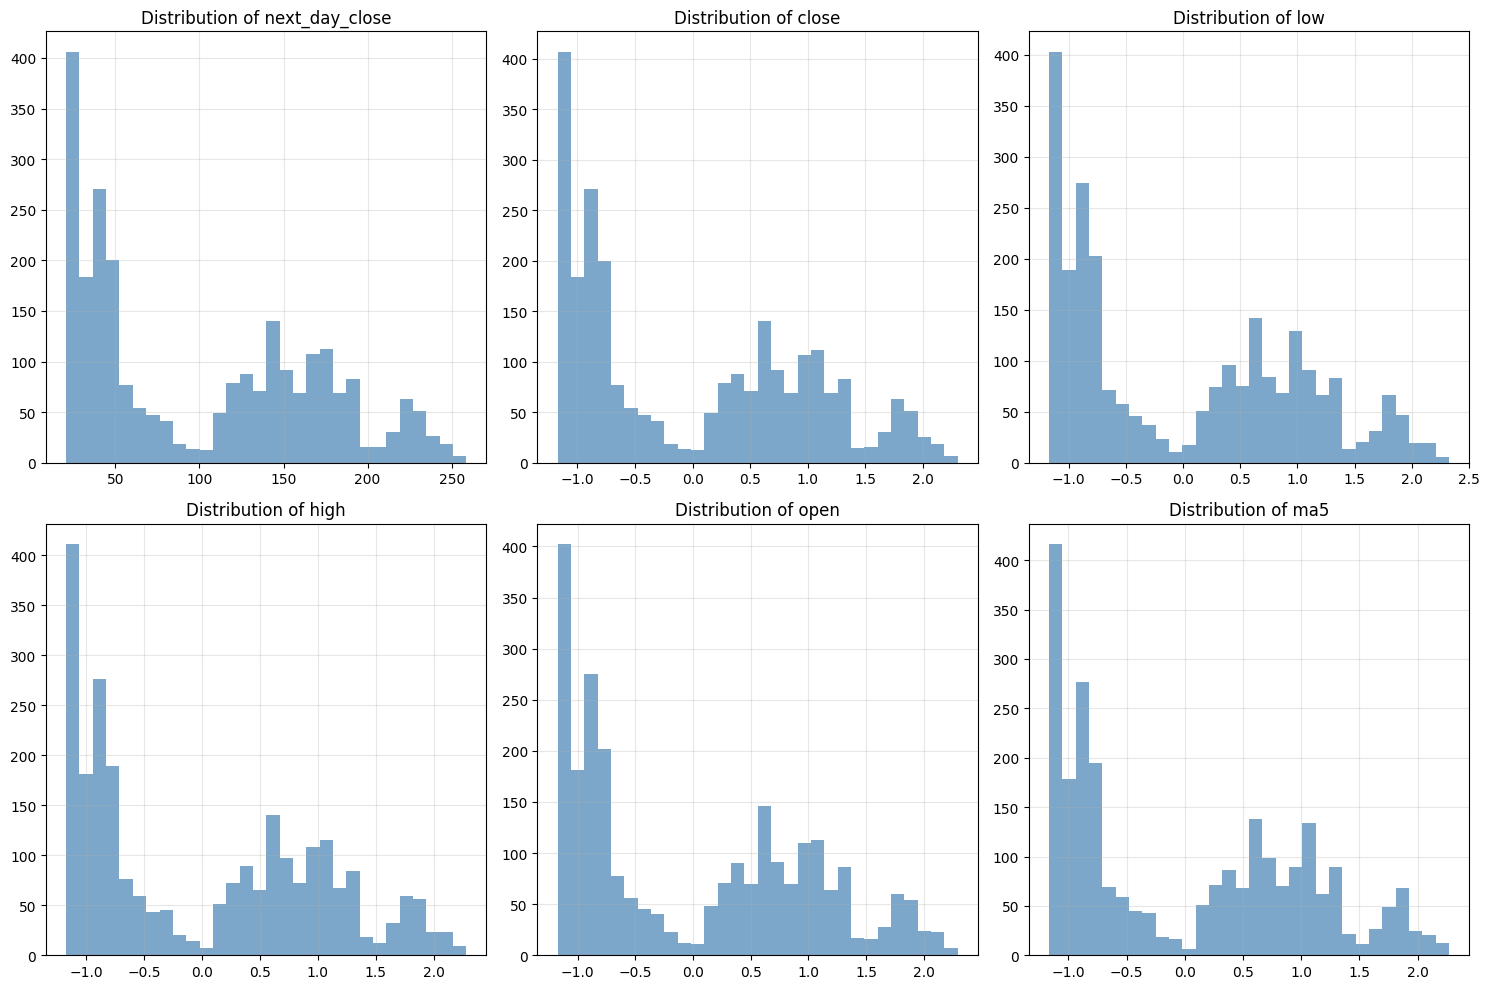

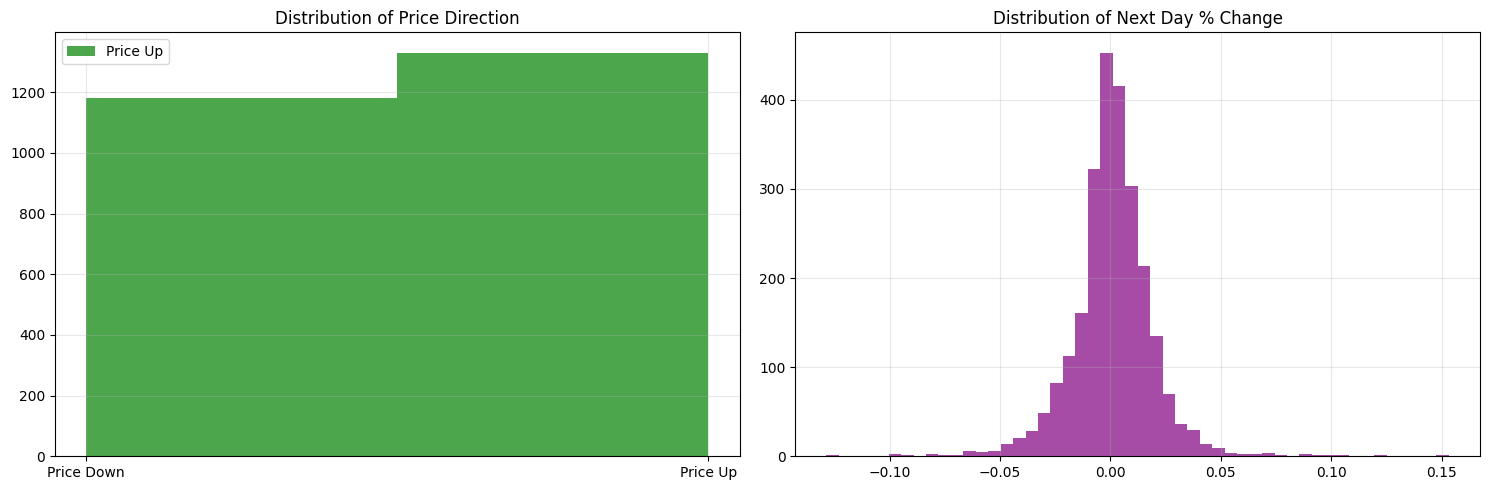

In [10]:
# Visualize distributions of key features
if os.path.exists(sample_file):
    # Select a subset of important features based on correlation analysis
    top_features = corr_with_next_day.head(6).index.tolist()
    
    # Plot histograms of top features
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(top_features, 1):
        plt.subplot(2, 3, i)
        plt.hist(sample_df[feature], bins=30, alpha=0.7, color='steelblue')
        plt.title(f'Distribution of {feature}')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot distribution of target variables
    plt.figure(figsize=(15, 5))
    
    # Price Up/Down distribution
    plt.subplot(1, 2, 1)
    plt.hist(sample_df['price_up'], bins=2, alpha=0.7, color='green', label='Price Up')
    plt.title('Distribution of Price Direction')
    plt.xticks([0, 1], ['Price Down', 'Price Up'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Next day percentage change distribution
    plt.subplot(1, 2, 2)
    plt.hist(sample_df['pct_change_next_day'], bins=50, alpha=0.7, color='purple')
    plt.title('Distribution of Next Day % Change')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Data Ready for XGBoost

Our data is now ready for training XGBoost models. The prepared datasets include:

1. Engineered features from raw price data
2. Technical indicators like RSI, MACD, Bollinger Bands
3. Time-based features (day of week, month, etc.)
4. Scaled feature values to optimize model training
5. Multiple target variables:
   - `next_day_close`: Regression target (scaled)
   - `price_up`: Classification target (0/1)
   - `pct_change_next_day`: Alternative regression target
6. Original price data for reference and evaluation

The data is saved in the `/data/xgboost/` directory with filenames like `STOCK_xgboost.csv`. 

Additionally, we've saved the scalers used for each stock in the `/models/scalers/` directory, which will be essential for transforming new data and interpreting model predictions.

## 8. Train/Test Split Strategy for XGBoost

When training XGBoost models with this data, we recommend the following approach:

1. **Chronological split**: Since this is time series data, use a chronological train/test split rather than random (e.g., train on first 80% of days, test on last 20%)

2. **Feature selection**: XGBoost can handle many features, but consider using the correlation analysis above as a starting point for feature selection

3. **Hyperparameter tuning**: XGBoost has many hyperparameters that can be tuned, such as:
   - `max_depth`: Maximum depth of trees
   - `learning_rate`: Step size shrinkage
   - `n_estimators`: Number of trees
   - `subsample`: Fraction of samples used for fitting trees
   - `colsample_bytree`: Fraction of features used for fitting trees

4. **Multiple objectives**: Consider training separate models for regression (predicting price) and classification (predicting direction)

5. **Evaluation metrics**:
   - For regression: RMSE, MAE, R²
   - For classification: Accuracy, Precision, Recall, F1-score

These recommendations can be implemented in the model training notebook.